<br> Choice of clearsky model in heliosat method for solar resourcing (GHI estimation)
<br> A comparison of Ineichen-Perez, McClear, Rest and improved Ineichen-Perez model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pvlib
plt.rcParams["font.family"] = "Times New Roman"
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read clear sky ghi of clear-sky models
df_g = pd.read_csv('dra_ghics_ghi_2019.csv')
df_g['time'] = pd.to_datetime(df_g['Unnamed: 0'])
df_g = df_g.set_index(df_g['time'])
df_g = df_g.drop(columns=['time','Unnamed: 0'])
df_g.head()

,ghics_pvlib,ghics_tl,ghics_mc,zen,ghi,ghi_ns,ghics_rest
time,,,,,,,
2019-01-01 12:05:00,0.0,0.0,0.0,123.650,NaN,0,0
2019-01-01 12:10:00,0.0,0.0,0.0,122.650,NaN,0,0
2019-01-01 12:15:00,0.0,0.0,0.0,121.650,NaN,0,0
2019-01-01 12:20:00,0.0,0.0,0.0,120.660,NaN,0,0
2019-01-01 12:25:00,0.0,0.0,0.0,119.662,NaN,0,0


In [3]:
# get the ci values of dra
df_c = pd.read_csv('ci_dra_2019.csv')
df_c['time'] = pd.to_datetime(df_c['time'])
df_c = df_c.set_index(df_c['time'])
df_c = df_c.drop(columns=['time.1','time'])
df_c.head()

,ci
time,
2019-01-01 16:05:00,0.007861
2019-01-01 16:10:00,0.073763
2019-01-01 16:15:00,0.019996
2019-01-01 16:20:00,0.005287
2019-01-01 16:25:00,0.017061


In [4]:
# combine dataset
df_a = pd.concat([df_g,df_c],axis=1,join='inner')
df_a = df_a.dropna() # drop NaN values
df_a.head()

,ghics_pvlib,ghics_tl,ghics_mc,zen,ghi,ghi_ns,ghics_rest,ci
time,,,,,,,,
2019-01-01 16:05:00,140.300612,156.313124,184.7688,79.396,154.18,174,174,0.007861
2019-01-01 16:10:00,155.411056,171.977689,200.6832,78.628,168.46,189,189,0.073763
2019-01-01 16:15:00,170.499527,187.561776,216.4620,77.870,182.98,44,203,0.019996
2019-01-01 16:20:00,185.519533,203.026862,232.0884,77.124,197.40,218,218,0.005287
2019-01-01 16:25:00,200.432172,218.340727,247.5360,76.386,211.72,52,233,0.017061


In [5]:
# ci to csi using M3
csi = []
for x in df_a['ci'].values:
    if x < -0.2:
        csi.append(1.2)
    if x >= -0.2 and x < 0.8:
        csi.append(1-x)
    if x >= 0.8 and x < 1.1:
        csi_ = 2.0667 - 3.6667*x + 1.6667*x*x
        csi.append(csi_)
    if x >= 1.1:
        csi.append(0.05)
len(df_a['ci']),len(csi)

(42440, 42440)

In [6]:
# GHI estimation based on csi and clear-sky models
df_a['csi'] = csi
df_a['ghi_pvlib'] = df_a['ghics_pvlib']*df_a['csi']
df_a['ghi_tl'] = df_a['ghics_tl']*df_a['csi']
df_a['ghi_rest'] = df_a['ghics_rest']*df_a['csi']
df_a['ghi_mc'] = df_a['ghics_mc']*df_a['csi']
df_a.head()

,ghics_pvlib,ghics_tl,ghics_mc,zen,ghi,ghi_ns,ghics_rest,ci,csi,ghi_pvlib,ghi_tl,ghi_rest,ghi_mc
time,,,,,,,,,,,,,
2019-01-01 16:05:00,140.300612,156.313124,184.7688,79.396,154.18,174,174,0.007861,0.992139,139.197666,155.084299,172.632133,183.316276
2019-01-01 16:10:00,155.411056,171.977689,200.6832,78.628,168.46,189,189,0.073763,0.926237,143.947395,159.292016,175.058701,185.880108
2019-01-01 16:15:00,170.499527,187.561776,216.4620,77.870,182.98,44,203,0.019996,0.980004,167.090194,183.811264,198.940783,212.133595
2019-01-01 16:20:00,185.519533,203.026862,232.0884,77.124,197.40,218,218,0.005287,0.994713,184.538771,201.953546,216.847528,230.861449
2019-01-01 16:25:00,200.432172,218.340727,247.5360,76.386,211.72,52,233,0.017061,0.982939,197.012564,214.615578,229.024746,243.312745


In [7]:
# get the dates to plot some time series data
dates = list(set(str(index)[:10] for index in df_a.index))
dates = pd.to_datetime(dates)
dates = dates.sort_values()
len(dates)

362

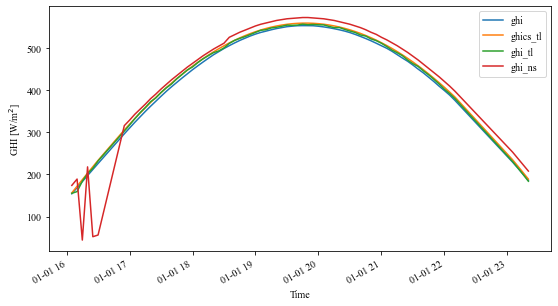

16.626165112234332 5.390724116613108 35.68776018291456 16.881007659395852
2019-01-01 00:00:00


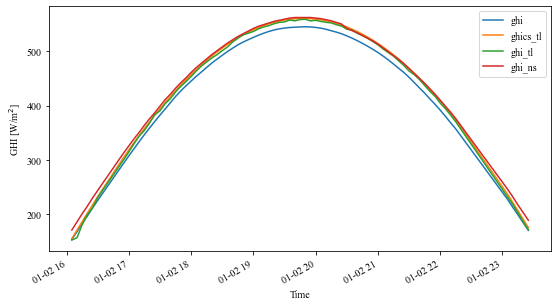

10.218381494799232 11.20888646459546 28.185383329704738 13.778216146211452
2019-01-02 00:00:00


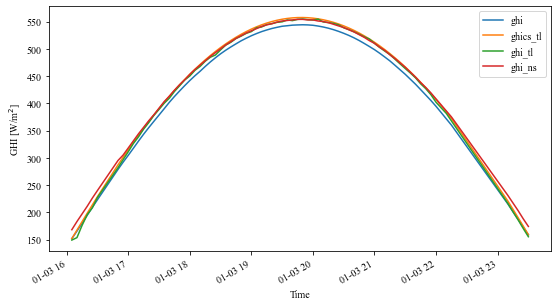

8.157623054054005 9.208809222995404 16.963193150455538 9.179952761972666
2019-01-03 00:00:00


In [8]:
# select a few days to show the results
for date in dates[:3]:
    dt = date
    dt_ = dt + datetime.timedelta(minutes=1440)
    
    times = pd.date_range(start=dt+datetime.timedelta(minutes=720),
                          end=dt_+datetime.timedelta(minutes=240),
                          freq='5min')
    times = [time for time in times if time in df_a.index]
    try:
        df_a.loc[times,['ghi','ghics_tl','ghi_tl','ghi_ns']].plot(figsize=(9,5),legend=True)
        plt.ylabel('GHI [W/m$^2$]')
        plt.xlabel('Time')
        plt.show()
        rmse1 = np.sqrt(metrics.mean_squared_error(df_a.loc[times,'ghi'],df_a.loc[times,'ghi_pvlib']))
        rmse2 = np.sqrt(metrics.mean_squared_error(df_a.loc[times,'ghi'],df_a.loc[times,'ghi_tl']))
        rmse3 = np.sqrt(metrics.mean_squared_error(df_a.loc[times,'ghi'],df_a.loc[times,'ghi_mc']))
        rmse4 = np.sqrt(metrics.mean_squared_error(df_a.loc[times,'ghi'],df_a.loc[times,'ghi_rest']))
        print(rmse1,rmse2,rmse3,rmse4)
        print(date)
    except:
        print (str(date)[:10]+' all nans')

In [9]:
rmse1 = np.sqrt(metrics.mean_squared_error(df_a['ghi'],df_a['ghi_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_a['ghi'],df_a['ghi_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_a['ghi'],df_a['ghi_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_a['ghi'],df_a['ghi_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_a['ghi'],df_a['ghi_ns']))
print(rmse1,rmse2,rmse3,rmse4,rmse5)

106.10165957030772 104.79089124738358 105.02853644285481 104.6637818546948 100.57011932692836


In [11]:
mae1 = metrics.mean_absolute_error(df_a['ghi'],df_a['ghi_pvlib'])
mae2 = metrics.mean_absolute_error(df_a['ghi'],df_a['ghi_tl'])
mae3 = metrics.mean_absolute_error(df_a['ghi'],df_a['ghi_mc'])
mae4 = metrics.mean_absolute_error(df_a['ghi'],df_a['ghi_rest'])
mae5 = metrics.mean_absolute_error(df_a['ghi'],df_a['ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

62.58187881095748 53.626599100116486 55.364369590772355 55.81981732720671 51.43415362865221


In [12]:
mbe1 = np.mean(df_a['ghi_pvlib'] - df_a['ghi'])
mbe2 = np.mean(df_a['ghi_tl'] - df_a['ghi'])
mbe3 = np.mean(df_a['ghi_mc'] - df_a['ghi'])
mbe4 = np.mean(df_a['ghi_rest'] - df_a['ghi'])
mbe5 = np.mean(df_a['ghi_ns'] - df_a['ghi'])
mbe1,mbe2,mbe3,mbe4,mbe5

(-11.930246219964024,
 4.775645898804744,
 6.947057501442407,
 0.8858461650845899,
 -8.409671065033061)

In [13]:
# cloudy day (0), partly cloudy (1), clear day (2)
df_c = pd.read_csv('clear_days_surfrad_2019.csv')
df_c['date'] = pd.to_datetime(df_c['date'])
df_c = df_c.set_index('date')
df_c.head()

,dra,bon,tbl,fpk,psu,sxf,gwn
date,,,,,,,
2019-01-01,2.0,NaN,NaN,NaN,NaN,NaN,0.0
2019-01-02,2.0,NaN,NaN,NaN,NaN,NaN,0.0
2019-01-03,2.0,NaN,NaN,NaN,NaN,NaN,0.0
2019-01-04,2.0,NaN,NaN,NaN,NaN,NaN,0.0
2019-01-05,0.0,NaN,NaN,NaN,NaN,NaN,1.0


In [15]:
# get the dataset in different sky conditions
# cloudy day (0), partly cloudy (1), clear day (2)

df_0 = pd.DataFrame()
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()

for date in df_c.index:
    if df_c.loc[date,'dra'] == 0:
        dt = date
        dt_ = dt + datetime.timedelta(days=1)
        times = pd.date_range(start=dt+datetime.timedelta(minutes=720),
                          end=dt_+datetime.timedelta(minutes=240),
                          freq='5min')
        times_ = [time for time in times if time in df_a.index]
        df_0 = pd.concat([df_0,df_a.loc[times_]])
    elif df_c.loc[date,'dra'] == 1:
        dt = date
        dt_ = dt + datetime.timedelta(days=1)
        times = pd.date_range(start=dt+datetime.timedelta(minutes=720),
                          end=dt_+datetime.timedelta(minutes=240),
                          freq='5min')
        times_ = [time for time in times if time in df_a.index]
        df_1 = pd.concat([df_1,df_a.loc[times_]])
    elif df_c.loc[date,'dra'] == 2:
        dt = date
        dt_ = dt + datetime.timedelta(days=1)
        times = pd.date_range(start=dt+datetime.timedelta(minutes=720),
                          end=dt_+datetime.timedelta(minutes=240),
                          freq='5min')
        times_ = [time for time in times if time in df_a.index]
        df_2 = pd.concat([df_2,df_a.loc[times_]])
    else:
        pass
df_0.shape,df_1.shape,df_2.shape

((10005, 13), (15930, 13), (12821, 13))

In [16]:
rmse1 = np.sqrt(metrics.mean_squared_error(df_0['ghi'],df_0['ghi_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_0['ghi'],df_0['ghi_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_0['ghi'],df_0['ghi_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_0['ghi'],df_0['ghi_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_0['ghi'],df_0['ghi_ns']))
mean = df_0['ghi'].mean()
print(rmse1,rmse2,rmse3,rmse4,rmse5,mean)

142.7020692678771 144.3552114152793 144.15932521405475 143.33605044357944 141.8589077022404 379.71647176411807


In [17]:
mae1 = metrics.mean_absolute_error(df_0['ghi'],df_0['ghi_pvlib'])
mae2 = metrics.mean_absolute_error(df_0['ghi'],df_0['ghi_tl'])
mae3 = metrics.mean_absolute_error(df_0['ghi'],df_0['ghi_mc'])
mae4 = metrics.mean_absolute_error(df_0['ghi'],df_0['ghi_rest'])
mae5 = metrics.mean_absolute_error(df_0['ghi'],df_0['ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

99.4652232511874 99.96075822876618 100.6138903193042 100.39007532927192 94.7135732133933


In [18]:
mbe1 = np.mean(-df_0['ghi']+df_0['ghi_pvlib'])
mbe2 = np.mean(-df_0['ghi']+df_0['ghi_tl'])
mbe3 = np.mean(-df_0['ghi']+df_0['ghi_mc'])
mbe4 = np.mean(-df_0['ghi']+df_0['ghi_rest'])
mbe5 = np.mean(-df_0['ghi']+df_0['ghi_ns'])
print(mbe1,mbe2,mbe3,mbe4,mbe5)

16.904013719862547 26.491502915646848 26.29092802994985 20.45059041488265 -16.137861069465256


In [19]:
rmse1 = np.sqrt(metrics.mean_squared_error(df_1['ghi'],df_1['ghi_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_1['ghi'],df_1['ghi_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_1['ghi'],df_1['ghi_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_1['ghi'],df_1['ghi_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_1['ghi'],df_1['ghi_ns']))
mean = df_1['ghi'].mean()
print(rmse1,rmse2,rmse3,rmse4,rmse5,mean)

104.56917561614965 103.05925159021778 103.56153527866451 103.28200369055747 98.40447086758529 587.3282297551799


In [20]:
mae1 = metrics.mean_absolute_error(df_1['ghi'],df_1['ghi_pvlib'])
mae2 = metrics.mean_absolute_error(df_1['ghi'],df_1['ghi_tl'])
mae3 = metrics.mean_absolute_error(df_1['ghi'],df_1['ghi_mc'])
mae4 = metrics.mean_absolute_error(df_1['ghi'],df_1['ghi_rest'])
mae5 = metrics.mean_absolute_error(df_1['ghi'],df_1['ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

60.04404824209626 51.7016420726912 54.27287809698421 54.84764940628711 50.88625109855618


In [21]:
mbe1 = np.mean(-df_1['ghi']+df_1['ghi_pvlib'])
mbe2 = np.mean(-df_1['ghi']+df_1['ghi_tl'])
mbe3 = np.mean(-df_1['ghi']+df_1['ghi_mc'])
mbe4 = np.mean(-df_1['ghi']+df_1['ghi_rest'])
mbe5 = np.mean(-df_1['ghi']+df_1['ghi_ns'])
print(mbe1,mbe2,mbe3,mbe4,mbe5)

17.29412698716564 -0.5819697815259175 -2.336179366906358 4.490514351828486 10.239466415568126


In [22]:
rmse1 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghi_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghi_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghi_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghi_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghi_ns']))
mean = df_2['ghi'].mean()
print(rmse1,rmse2,rmse3,rmse4,rmse5,mean)

31.611755717682968 14.369010450123964 15.908590436764404 16.015789217711134 14.607157478117209 625.8489852585574


In [23]:
mae1 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghi_pvlib'])
mae2 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghi_tl'])
mae3 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghi_mc'])
mae4 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghi_rest'])
mae5 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

27.456953349803648 9.7317451612125 11.261302276976128 11.73506771213256 10.881453864753139


In [24]:
mbe1 = np.mean(-df_2['ghi']+df_2['ghi_pvlib'])
mbe2 = np.mean(-df_2['ghi']+df_2['ghi_tl'])
mbe3 = np.mean(-df_2['ghi']+df_2['ghi_mc'])
mbe4 = np.mean(-df_2['ghi']+df_2['ghi_rest'])
mbe5 = np.mean(-df_2['ghi']+df_2['ghi_ns'])
print(mbe1,mbe2,mbe3,mbe4,mbe5)

26.71927735062785 4.979394571942478 -1.6788768370311427 4.130601872122484 -1.2599766008891633


In [25]:
rmse1 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghics_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghics_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghics_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghics_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_2['ghi'],df_2['ghi_ns']))
print(rmse1,rmse2,rmse3,rmse4,rmse5)

25.64803181456898 9.87527715840957 15.580517733066516 12.955519304379237 14.607157478117209


In [26]:
mae1 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghics_pvlib'])
mae2 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghics_tl'])
mae3 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghics_mc'])
mae4 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghics_rest'])
mae5 = metrics.mean_absolute_error(df_2['ghi'],df_2['ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

22.38385961138666 7.623652192436445 12.389671632477969 10.520252710397004 10.881453864753139


In [27]:
mbe1 = np.mean(-df_2['ghi']+df_2['ghics_pvlib'])
mbe2 = np.mean(-df_2['ghi']+df_2['ghics_tl'])
mbe3 = np.mean(-df_2['ghi']+df_2['ghics_mc'])
mbe4 = np.mean(-df_2['ghi']+df_2['ghics_rest'])
mbe5 = np.mean(-df_2['ghi']+df_2['ghi_ns'])
print(mbe1,mbe2,mbe3,mbe4,mbe5)

21.050370881221824 -0.9322287482639581 -7.6968738787925695 -1.836374697761484 -1.2599766008891633


In [28]:
df = pd.read_csv('DRA_19_cloudy_clear.csv')
df['utc'] = pd.to_datetime(df['lst'])+datetime.timedelta(hours=8) # for dra, time difference is 8 hrs.
df = df.set_index('utc')
df.head()

,lst,zen,ghi,dhi,dni_ex,ghics,dhics,exth,year,month,day,hour,minute,second,cloudy
utc,,,,,,,,,,,,,,,
2019-01-01 15:30:00,2019-01-01 07:30:00,84.97,57.4,22.2,1414.0,40.846,4.9734,123.97,2019,1,1,7,30,0,1
2019-01-01 15:31:00,2019-01-01 07:31:00,84.80,60.0,22.6,1414.0,43.289,5.2218,128.15,2019,1,1,7,31,0,1
2019-01-01 15:32:00,2019-01-01 07:32:00,84.64,62.7,23.1,1414.0,45.774,5.4722,132.08,2019,1,1,7,32,0,1
2019-01-01 15:33:00,2019-01-01 07:33:00,84.48,65.3,23.6,1414.0,48.299,5.7243,136.02,2019,1,1,7,33,0,1
2019-01-01 15:34:00,2019-01-01 07:34:00,84.32,67.7,24.1,1414.0,50.861,5.9779,139.95,2019,1,1,7,34,0,1


<br> utc: UTC time, lst: Local standard time, zen: solar zenith angle, ghi: global horizontal irradiance, dhi: diffuse horizontal irradiance, dni_ex: extraterrestrial radiation, ghics: clear sky ghi, dhics: clear sky dhi, exth: horizontal projection of dni_ex,
cloudy: cloudy flag, 1 means cloudy.
<br> Clear-sky detection is performed using the Bright-Sun model, please refer to https://github.com/JamieMBright/csd-library for more details.

In [37]:
# cloudy or clear periods in a resolution of 5-min
# e.g., if it is detected clear at 15:03, 15:04, 15:05, 15:06, and 15:07, then it is marked as clear in these 5 mins and indexed by 15:05
clear_index = []
time_5min = pd.date_range(start='2019',end='2020',freq='5min')
for time in time_5min:
    if time in df.index:
        dt = time - datetime.timedelta(minutes = 2)
        dt_ = time + datetime.timedelta(minutes = 2)
        times = pd.date_range(start=dt,end=dt_,freq='1min')
        times_ = [t for t in times if t in df.index]
        if len(times)== len(times_):
            if sum(df.loc[times_,'cloudy'].values) == 0:
                clear_index.append(time)
len(clear_index)

18690

In [31]:
cloudy = [index for index in df_a.index if index not in clear_index]
clear = [index for index in df_a.index if index in clear_index]
len(cloudy),len(clear),len(df_a)

(24553, 17887, 42440)

In [36]:
#cloudy conditions
#rmse
rmse1 = np.sqrt(metrics.mean_squared_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_ns']))
print(rmse1,rmse2,rmse3,rmse4,rmse5)

136.64686980282133 136.9311050483452 137.03324217307704 136.48668593439933 131.62024767852915


In [38]:
#cloudy conditions
#mae
mae1 = metrics.mean_absolute_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_pvlib'])
mae2 = metrics.mean_absolute_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_tl'])
mae3 = metrics.mean_absolute_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_mc'])
mae4 = metrics.mean_absolute_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_rest'])
mae5 = metrics.mean_absolute_error(df_a.loc[cloudy,'ghi'],df_a.loc[cloudy,'ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

88.45667119597623 84.93750564672253 86.49704940451237 86.84955752192204 80.90820347819005


In [39]:
#cloudy conditions
#mbe
mbe1 = np.mean(-df_a.loc[cloudy,'ghi']+df_a.loc[cloudy,'ghi_pvlib'])
mbe2 = np.mean(-df_a.loc[cloudy,'ghi']+df_a.loc[cloudy,'ghi_tl'])
mbe3 = np.mean(-df_a.loc[cloudy,'ghi']+df_a.loc[cloudy,'ghi_mc'])
mbe4 = np.mean(-df_a.loc[cloudy,'ghi']+df_a.loc[cloudy,'ghi_rest'])
mbe5 = np.mean(-df_a.loc[cloudy,'ghi']+df_a.loc[cloudy,'ghi_ns'])
print(mbe1,mbe2,mbe3,mbe4,mbe5)

-1.4510130622634245 12.062455693391795 12.197265690179101 6.702175607075697 -13.85285382641633


In [40]:
#clear conditions
#rmse
rmse1 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_ns']))
print(rmse1,rmse2,rmse3,rmse4,rmse5)

32.85514474421775 17.79999463920044 19.918267010125547 20.505290458189815 14.765088212062619


In [41]:
#clear conditions
#mae
mae1 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_pvlib'])
mae2 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_tl'])
mae3 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_mc'])
mae4 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_rest'])
mae5 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

27.064252745694144 10.64696649326133 12.629383988560786 13.226134149432577 10.97592441437916


In [42]:
#clear conditions
#mbe
mbe1 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghi_pvlib'])
mbe2 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghi_tl'])
mbe3 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghi_mc'])
mbe4 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghi_rest'])
mbe5 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghi_ns'])
print(mbe1,mbe2,mbe3,mbe4,mbe5)

-26.31480549323643 -5.226760367561491 -0.25976095095599083 -7.0980715846335265 -0.9379616481243264


In [43]:
#clear conditions, ghics vs ghi
#rmse
rmse1 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_pvlib']))
rmse2 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_tl']))
rmse3 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_mc']))
rmse4 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_rest']))
rmse5 = np.sqrt(metrics.mean_squared_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_ns']))
print(rmse1,rmse2,rmse3,rmse4,rmse5)

24.919430899170603 10.258075032440127 15.722365109764525 13.313926513723747 14.765088212062619


In [44]:
#clear conditions, ghics vs ghi
#mae
mae1 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_pvlib'])
mae2 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_tl'])
mae3 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_mc'])
mae4 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghics_rest'])
mae5 = metrics.mean_absolute_error(df_a.loc[clear,'ghi'],df_a.loc[clear,'ghi_ns'])
print(mae1,mae2,mae3,mae4,mae5)

21.289825985354714 8.058498139395986 12.580418516240847 10.616268798568793 10.97592441437916


In [46]:
#clear conditions, ghics vs ghi
#mbe
mbe1 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghics_pvlib'])
mbe2 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghics_tl'])
mbe3 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghics_mc'])
mbe4 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghics_rest'])
mbe5 = np.mean(-df_a.loc[clear,'ghi']+df_a.loc[clear,'ghi_ns'])
print(mbe1,mbe2,mbe3,mbe4,mbe5)

-19.838241669585834 1.4835867615328542 6.515654251691152 -0.3935439145748307 -0.9379616481243264
